# Multi-Agent Workflows

Con i sottografi abbiamo visto come integrare grafi indipendenti dentro sistemi più grandi.

Quando sviluppiamo Agenti, la funzionalità diventa più complessa lungo il tempo, e questo può diventare difficile gestire tutto quanto all'interno di un singolo agente.

Qui è dove entrano in gioco i sistemi multi-agente.

La necessità di sistemi multi-agente si solleva quando parti specifiche della nostra appicazione richiedono un focus specializzato, come il planning, decision making o eseguire tasks complessi.

Dividendo le funzionalità in molteplici agenti indipendenti, ciascuno con un chiaro e preciso ruolo, guadagniamo modularità, scalabilità e miglior controllo.

I sistemi multi-agente consentono la specializzazione esperta dove un agente potrebbe essere un ricercatore, un'altro un pianificatore, e un'altro ancora un problem solver, lavorando tutti assieme ininterrottamente.

Questo approccio assicura che il nostro sistema rimanga gestibile, efficiente e adattabile anche quando la sia complessità cresce.

Ci sono molteplici **patterns** per progettare (pattern designs) milti-agent systems, ciascuno di essi adatto per diversi use cases e livello di complessità.

![alt text](patterns.png)

## Single-agent pattern

Un singolo agente interagisce con i tools direttamente, ciò è adatto per semplici workflows dove un agente controlla l'intero processo.


## Network pattern:

Gli agenti sono connessi in una struttura many-to-many, permettendo a ciascun agente di comunicare e passare i tasks a ciascun altro agente.

Questo pattern funziona bene con una gerarchia non predefinita o ordine.

## Supervisor pattern:

Un agente centrale supervisore decide quale agenti specializzati chiamare per il prossimo step.

Questo pattern fornisce un controllo centralizzato e funziona bene per i workflow sequenziali.

## Agents as Tools pattern:

Un approccio simile al Supervisor è il **supervisor as tool**, in questa variante, agenti individuali sono trattati come tools.

Il supervisore decide quale agente chiamare e fornisce gli argomenti ad esso.

## Hierachical pattern:

Molteplici supervisori gestiscono il loro proprio team di agenti, con un supervisore top-level che coordina tra gli agenti.

Tale struttura è ideale per sistemi davvero grandi e complessi che richiedono una struttura chiara e gerarchica.

## Custom pattern:

Abbiamo anche la possibilità di fare il nostro custom workflow.

Gli agenti sono connessi in un workflow customizzato dove alcune parti sono deterministiche (senza utilizzo degli LLMs) e altre hanno agenti che decidono quali agenti chiamare.

Questo pattern è molto flessibile e possiamo adattarlo in base ai nostri requisiti.


## Re-cap
Tutti questi patterns hanno diversi vantaggi e compromessi, il loro utilizzo dipende dalla complessità del nostro sistema e dalla necessità di specializzazione o controllo.

# Caso di studio 

Di seguito progetteremo un workflow complesso multi-agent per un football news agency.

Il sistema includerà agenti specializzati, ciascuno di essi gestirà task specifici.

Ad esempio, un agente ricercatore dovrà raccogliere informazioni come il player market value (valore di mercato di un giocatore), mentre un'altro agente dovrà retrievare l'informazione circa la squadra attuale del giocatore.

Inoltre, un agente text writer dovrà creare un articolo di blog basato sui dati raccolti, operando indipendentemente dagli altri agenti.

Un agente supervisore coordinerà il workflow, assegnando i compiti agli agenti esperti/specializzati ed assicuarndo che ciascuno step sia completato.

Una volta che i tasks sono completati, l'agente supervisore sarà il responsabile per la pubblicazione dell'articolo.

Importante da notare è che mentre l'agente supervisore ispeziona l'intero processo, gli agenti esperti non comunicheranno tra di loro, dunque enfatizzeremo i ruoli chiari e modulari all'interno del sistema.

Iniziamo con l'implementazione degli agenti esperti indipendenti prima di creare l'agente supervisore.

Iniziamo con il primo agente esperto che è una agente che retrieva il current club (squadra corrente) da un database fake.

In [9]:
from dotenv import load_dotenv
load_dotenv()

True

In [19]:
from typing import TypedDict, Literal, Annotated, List
from operator import add
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

# definiamo un InputState ed un OutputState perchè vogliamo un agente snello
# Snello significa che l'agente esperto lavorerà con due records e creerà la sua 
# propria history che salveremo nel messages object.
# Tuttavia l'agente supervisore è interessato solo alla risposta finale
# quindi forniamo solo l'output dell'agente esperto all'agente supervisore 
class InputState(TypedDict):
    article: str

class OutputState(TypedDict):
    agent_output: str

class OverallState(InputState, OutputState):
    messages: Annotated[List[BaseMessage], add]

# l'agente esperoìto sarà responsabile di ottenere la squadra corrente di un giocatore
@tool
def get_current_club(player_name: str):
    """Gets current club of a player."""
    fake_db = {
        "Lionel Messi": "Paris Saint-Germain",
        "Cristiano Ronaldo": "Al Nassr FC",
    }
    return fake_db.get(player_name, "Current club information not available.")

tools1 = [get_current_club]
model_1 = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools1)


In [20]:
def call_model_current_club(state: OverallState):
    local_messages = state.get('messages', [])

    if not local_messages:
      human_message = HumanMessage(content=state['article'])
      local_messages.append(human_message)

    system_message = SystemMessage(content="""You are an agent tasked with determining the current club of a player.
    If the current club is metioned, return it. Otherwise, return 'Current club information not available.'""") 
    
    response = model_1.invoke([system_message] + local_messages) 

    state['agent_output'] = response.content

    state['messages'] = local_messages + [response]

    return state

# funzione per l'arco condizionale
def should_continue(state: OverallState) -> Literal["tools", END]:
    last_message = state["messages"][-1]
    if getattr(last_message, "tool_calls", None):
        return "tools"
    else:
        return END

tool_node = ToolNode(tools1)

current_club_graph = StateGraph(OverallState, input=InputState, output=OutputState)

current_club_graph.add_node("call_model_current_club", call_model_current_club)
current_club_graph.add_node("tools", tool_node)
current_club_graph.add_edge(START, "call_model_current_club")
current_club_graph.add_conditional_edges(
    "call_model_current_club", 
    should_continue,
    path_map={
        "tools": "tools",
        END: END
    }
    )

current_club_graph.add_edge(
    "tools",
    "call_model_current_club"
)

current_club_graph.add_edge("call_model_current_club", END)


current_club_researcher_agent = current_club_graph.compile()

In [21]:
initial_state = {"article": "Lionel Messi will join Real Madrid 2025"}

current_club_reasearcher_agent.invoke(initial_state)

{'agent_output': 'Lionel Messi is currently playing for Paris Saint-Germain.'}

In [22]:
initial_state = {"article": "Thomas Muller will join Real Madrid 2025"}

current_club_researcher_agent.invoke(initial_state)

{'agent_output': 'Current club information not available.'}

Dato che il primo agente funziona correttamente procediamo con la creazione del secondo agente che retrieva il market value di un giocatore.

Anche col secondo agente diamo in output solo la risposta finale dunque creiamo lo stato snello (cioè suddiviso in più parti).

In [26]:
class InputState(TypedDict):
    article: str

class OutputState(TypedDict):
    agent_output: str

class OverallState(InputState, OutputState):
    messages: Annotated[List[BaseMessage], add]

@tool
def get_market_value(player_name: str):
    """Gets current market value of a player"""
    fake_market_value_db = {
        "Lionel Messi": "$50 million",
        "Cristiano Ronaldo": "$30 million"
    }
    return fake_market_value_db.get(player_name, "Market value information not available.")


tools2 = [get_market_value]

model_2 = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools2)

def call_model_market_value(state: OverallState):
    local_messages = state.get("messages", [])
    if not local_messages:
        human_message = HumanMessage(content=state['article'])
        local_messages.append(human_message)

    system_message = SystemMessage(content="""You are an agent tasked with determining the market value of a palyer.
    If the market value is mentioned, return it. Otherwise, return 'Market value information not available.'""")

    response = model_2.invoke([system_message] + local_messages)

    state['agent_output'] = response.content

    state['messages'] = local_messages + [response]

    return state

def should_continue(state: OverallState) -> Literal['tools', END]:
    last_message = state['messages'][-1]

    if getattr(last_message, "tool_calls", None):
        return "tools"
    else:
        return END
    
market_value_graph = StateGraph(OverallState, input=InputState, output=OutputState)
market_value_graph.add_node("call_model_market_value", call_model_market_value)
market_value_graph.add_node("tools", ToolNode(tools2))
market_value_graph.add_edge(START, "call_model_market_value")
market_value_graph.add_conditional_edges("call_model_market_value", should_continue)
market_value_graph.add_edge("tools", "call_model_market_value")

market_value_researcher_agent = market_value_graph.compile()

In [27]:
market_value_researcher_agent.invoke({"article": "Lionel Messi will switch from FC Barcelona to Real Madrid in 2025"})

{'agent_output': 'The market value of Lionel Messi is $50 million.'}

In [28]:
market_value_researcher_agent.invoke({"article": "Thomas Muller will join Real Madrid 2025"})

{'agent_output': 'Market value information not available.'}

Dunque, abbiamo i nostri due agenti specializzati nel retrievare il club corrente ed il market value di un determinato giocatore.

Il nostro terzo agente è un agente che convertirà queste semplici informazioni, come 'Lionel Messi will switch from FC Barcelona to Real Madrid in 2025' in un articolo di 100 parole.

Anche qui usiamo lo stato snello.

In [29]:
class InputState(TypedDict):
    article: str

class OutputState(TypedDict):
    agent_output: str

class OverallState(InputState, OutputState):
    pass

# stavolta non necessitiamo di un tool

model_text_writer = ChatOpenAI(model="gpt-4o-mini")

def expand_text_to_100_words(state: OverallState):
    human_message = HumanMessage(content=state['article'])
    system_message = SystemMessage(content="Expand the following text to be at least 100 words. Maintain the original meaning while adding detail.")

    response = model_text_writer.invoke([system_message, human_message])

    state['agent_output'] = response.content

    return state

text_writer_graph = StateGraph(OverallState, input=InputState, output=OutputState)

text_writer_graph.add_node("expand_text_to_100_words", expand_text_to_100_words)
text_writer_graph.add_edge(START, "expand_text_to_100_words")
text_writer_graph.add_edge("expand_text_to_100_words", END)

text_writer_agent = text_writer_graph.compile()

In [30]:
text_writer_agent.invoke({'article': "Lionel Messi will switch from FC Barcelona to Real Madrid in 2025"})

{'agent_output': "Lionel Messi, one of the most celebrated football players in history, is set to make a significant transition in his illustrious career by moving from FC Barcelona to their arch-rivals, Real Madrid, in the year 2025. This monumental switch, which has been the subject of much speculation among fans and analysts alike, marks a major shift in the landscape of football. Messi, who has spent the majority of his professional life at Barcelona, where he achieved numerous records and accolades, will bring his exceptional skills and experience to Real Madrid, a club with its own rich legacy. This decision is poised to ignite fierce discussions among supporters of both clubs and could have a profound impact on the dynamics of La Liga. The potential transfer not only highlights Messi's versatility and ambition but also raises questions about the future strategies of both teams as they navigate the ever-evolving world of football."}

## Supervisor Agent

Il nostro agente supervisore prende l'articolo e lo valuta in base a diversi criteri.

Prima di tutto l'articolo sarà valutato se è on o off topic.

Se è off-topic allora non procediamo.

Dunque, l'agente supervisore dovrebbe valutare l'articolo se è riguardante a football transfers, yes or no.

Poi vogliamo sapere se il **market value** è menzionato, yes or no.

Se è menzionato, allora non dobbiamo passarlo all'agente specializzato **market_value_researcher**.

Lo stesso ragionamento lo facciamo per il **current club information**.
Se il current club è menzionato, allora non dobbiamo fornire l'articolo all'agente specilaizzato **current_club_researcher**.

Lo stesso facciamo per il text writer.

Se l'articolo ha già 100 parole e tutte queste informazioni sono nell'articolo, allora abbiamo bidìsogno del text writer per scrivere un nuovo articolo, ma possiamo passarlo così com'è. Per determninare ciò andremo ad usare il structured output quindi creando una classe Pydantic.

In [37]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

class ArticlePostabilityGrader(BaseModel):
    """Binary scores for verifyung if an article mentions market value, current club, and meets the minimum word count of 100 words."""

    off_or_ontopic: str = Field(
        description="The Article is about football transfers, 'yes' or 'no'"
    )
    mentions_market_value: str = Field(
        description="The article mentions market the player's market value, 'yes' or 'no'"
    )
    mentions_current_club: str = Field(
        description="The article mentions the player's current club, 'yes' or 'no'"
    )
    meets_100_words: str = Field(
        description="The article has at least 100 words, 'yes' or 'no'"
    )

llm_postability = ChatOpenAI(model="gpt-4o-mini", temperature=0)

structured_llm_postability_grader = llm_postability.with_structured_output(
    ArticlePostabilityGrader
)

postability_system = """
You are a grader assessing whether a news article meets the following criteria:
1. The article is about football transfers or not. If yes answer with 'yes', anotherwise with 'no'.
2. The article explicity mentions the player's market value, for example, by stating "market value" or a specific currency amout (e.g. $50 million) If this is present, respond with 'yes' for mentions_market_value; otherwise, responnd 'no'.
3. The article mentions the player's current club or indicates that the current club information is unvailable (e.g., "Current club information not available"). If this is present, respond with 'yes' for mentions_current_club; otherwise, respond 'no'. 
4. The article contains at least 100 words. If this is met, respond with 'yes' for meets_100_words; otherwise, respond 'no'.

Provide four binary scores ('yes' or 'no') as follows:
- off_or_ontopic: 'yes' or 'no' depending on whether the article is related to football transfers or not.
- mentions_market_value: 'yes' or 'no' depending on whether the article mentions the player's market value.
- mentions_current_club: 'yes' or 'no' depending on whether the article mentions the player's current club or states that the information is unavailable.
- meets_100_words: 'yes' or 'no' depending on whether the article has at least 100 words.
"""

postability_grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", postability_system),
        ("human", "News article: \n\n{article}")
    ]
)

# LCEL
news_chef = postability_grade_prompt | structured_llm_postability_grader

In [38]:
news_chef.invoke({"article": "Lionel Messi will switch to Real Madrid in 2025"})

ArticlePostabilityGrader(off_or_ontopic='yes', mentions_market_value='no', mentions_current_club='no', meets_100_words='no')

In [39]:
news_chef.invoke({"article": "Today in Munich will be 9 degrees"})

ArticlePostabilityGrader(off_or_ontopic='no', mentions_market_value='no', mentions_current_club='no', meets_100_words='no')

Ora abbiamo 4 agenti che lavorano indipendentemente, possiamo combinare questi 4 agenti in un unico grafo.

## Workflow

In [44]:
from typing import TypedDict, Literal
from langgraph.graph import END, StateGraph

# creiamo lo stato snello (InputState, OtputState e IntermidiateState)
class InputArticleState(TypedDict):
    article: str

class OutputFinalArticleState(TypedDict):
    final_article: str
    off_or_ontopic: str

# stato intermedio (solo il news_chef agent è interessato ad esso)
# gli attributi di questo stato vengono usati per scrivere il final_article
# ma non abbiamo bisogno di questi attributi come output
class SharedArticleState(InputArticleState, OutputFinalArticleState):
    mentions_market_value: str
    mentions_current_club: str
    meets_100_words: str

def update_article_state(state: SharedArticleState) -> SharedArticleState:
    response = news_chef.invoke({"article": state['article']})
    state["off_or_ontopic"] = response.off_or_ontopic
    state["mentions_market_value"] = response.mentions_market_value
    state["mentions_current_club"] = response.mentions_current_club
    state["meets_100_words"] = response.meets_100_words
    print("State after update_article_state:", state)
    return state

# mettiamo gli agenti specializzati (grafi) dentro dei nodi di questo nuovo grafo

# funzione che usa l'agente che cerca il market value
def market_value_researcher_node(state: SharedArticleState) -> SharedArticleState:
    # invochiamo il grafo che fa l'agente specializzato
    response = market_value_researcher_agent.invoke({"article": state["article"]})
    state['article'] += f" {response['agent_output']}"
    return state

def current_club_researcher_node(state: SharedArticleState) -> SharedArticleState: 
    # invochiamo il grafo che fa l'agente specializzato
    response = current_club_researcher_agent.invoke({"article": state["article"]})
    state['article'] += f" {response['agent_output']}"

    return state

def word_count_rewriter_node(state: SharedArticleState) -> SharedArticleState:
    response = text_writer_agent.invoke({"article": state["article"]})
    state['article'] += f" {response['agent_output']}"
    state["final_article"] = response['agent_output']
    return state

# news_chef compila gli attibuti dello stato
# intermedio ed in base a questi decidiamo verso quale agente (nodo) andare
def news_chef_decider(state: SharedArticleState) -> Literal['market_value_researcher', 'current_club_researcher', 'word_count_rewriter', END]:
    if state["off_or_ontopic"] == 'no':
        return END
    if state["mentions_market_value"] == "no":
        return "market_value_researcher"
    elif state["mentions_current_club"] == "no":
        return "current_club_researcher"
    elif state["meets_100_words"] == "no" and state["mentions_market_value"] == "yes" and state["mentions_current_club"] == "yes":
        return "word_count_rewriter"
    else:
        return END # se tutti gli attributi sono a "yes" allora restituiamo lo stato con il final_article 

In [45]:
# ora possiamo creare il nostro workflow

workflow = StateGraph(SharedArticleState, input=InputArticleState, output=OutputFinalArticleState)

workflow.add_node("news_chef", update_article_state)
workflow.add_node("market_value_researcher", market_value_researcher_node)
workflow.add_node("current_club_researcher", current_club_researcher_node)
workflow.add_node("word_count_rewriter", word_count_rewriter_node)

workflow.set_entry_point("news_chef")

workflow.add_conditional_edges(
    "news_chef",
    news_chef_decider,
    {
        "market_value_researcher": "market_value_researcher",
        "current_club_researcher": "current_club_researcher",
        "word_count_rewriter": "word_count_rewriter",
        END: END,
    },
)

# i loop
workflow.add_edge("market_value_researcher", "news_chef")
workflow.add_edge("current_club_researcher", "news_chef")
workflow.add_edge("word_count_rewriter", "news_chef")

app = workflow.compile()

In [46]:
app.invoke({"article": "Today in Munich will be 9 degrees"})

State after update_article_state: {'article': 'Today in Munich will be 9 degrees', 'off_or_ontopic': 'no', 'mentions_market_value': 'no', 'mentions_current_club': 'no', 'meets_100_words': 'no'}


{'off_or_ontopic': 'no'}

In [47]:
app.invoke({"article": "Lionel Messi will to Real Madrid in 2025"})

State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025', 'off_or_ontopic': 'yes', 'mentions_market_value': 'no', 'mentions_current_club': 'no', 'meets_100_words': 'no'}
State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is $50 million.', 'off_or_ontopic': 'yes', 'mentions_market_value': 'yes', 'mentions_current_club': 'no', 'meets_100_words': 'no'}
State after update_article_state: {'article': "Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is $50 million. Lionel Messi's current club is Paris Saint-Germain.", 'off_or_ontopic': 'yes', 'mentions_market_value': 'yes', 'mentions_current_club': 'yes', 'meets_100_words': 'no'}
State after update_article_state: {'article': "Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is $50 million. Lionel Messi's current club is Paris Saint-Germain. Lionel Messi, the renowned Argentine footballer, is 

{'final_article': "Lionel Messi, the renowned Argentine footballer, is expected to make a significant move to Real Madrid in 2025, a transfer that has the potential to shake up the footballing world. As of now, Messi plays for Paris Saint-Germain (PSG), where he has continued to showcase his extraordinary skills and goal-scoring ability. His impressive performances have kept his market value at a remarkable $50 million, a testament to his enduring talent and influence on the field. Fans and analysts alike are eagerly anticipating how this potential transfer will unfold, as Messi's move to one of PSG's biggest rivals could create a new chapter in his illustrious career and further intensify the historic rivalry between the two clubs.",
 'off_or_ontopic': 'yes'}

## Add Human in the Loop

Aggiungiamo un utente umano che revisiona il contenuto prima che venga pubblicato. Aggiungiamo il workflow dell'app come un nodo (sottografo) di un grafo più grade.

Come sappiamo quando aggiungiamo l'human in the loop dobbiamo salvare tutti gli stati in modo da fermare il flusso e riprenderlo da un punto specifico. Questo lo facciamo con i checkpointers.

Dunque, arrestiamo il workflow e esaminiamo se l'agente supervisore (news_chef) crea un risultato desiderato o non desiderato.

Nelle applicazioni del mondo reale con una UI, di norma abbiamo un API layer tra l'agente e l'UI. E postiamo l'articolo in un database o cose del genere, e normalmente le API ci danno una risposta se l'articolo è stato salvato con successo nel db o meno. Quindi abbiamo come risposta un testo (api_response) e lo status_code come 200.

In [108]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

class InputState(TypedDict):
    question: str

class IntermediateState(InputState):
    off_or_ontopic: str
    answer: str

class FinalState(IntermediateState):
    api_response: str
    status_code: int

In [109]:
def input_node(state: InputState) -> InputState:
    return state

def newsagent_node(state: IntermediateState) -> IntermediateState:
    response = app.invoke({"article": state['question']})
    state['answer'] = response.get("final_article", "Article not relevant for news agency")
    state["off_or_ontopic"] = response["off_or_ontopic"]

    return state

def api_call_node(state: FinalState) -> FinalState:
    state["status_code"] = 200
    state["api_response"] = f"API received answer: {state['answer']}"
    return state

In [110]:
workflow = StateGraph(FinalState, input=InputState, output=FinalState)

workflow.add_node("newsagent_node", newsagent_node)
workflow.add_node("api_call_node", api_call_node)

workflow.set_entry_point("newsagent_node")

workflow.add_edge("newsagent_node", "api_call_node")
workflow.add_edge("api_call_node", END)

In [111]:
human_app = workflow.compile(checkpointer=checkpointer, interrupt_after=["newsagent_node"])

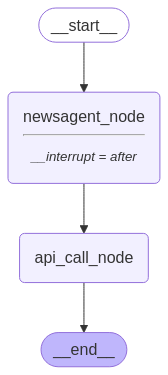

In [112]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        human_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [113]:
config = {"configurable": {"thread_id": "1"}}
config2 = {"configurable": {"thread_id": "2"}}


In [114]:
human_app.invoke({"question": "The weather will be 9 degrees in Munich"}, config=config2, subgraphs=True)

State after update_article_state: {'article': 'The weather will be 9 degrees in Munich', 'off_or_ontopic': 'no', 'mentions_market_value': 'no', 'mentions_current_club': 'no', 'meets_100_words': 'no'}


((),
 {'question': 'The weather will be 9 degrees in Munich',
  'off_or_ontopic': 'no',
  'answer': 'Article not relevant for news agency'})

In [115]:
snapshot = human_app.get_state(config2)
snapshot.next

('api_call_node',)

In [116]:
human_app.invoke(None, config=config2)

{'question': 'The weather will be 9 degrees in Munich',
 'off_or_ontopic': 'no',
 'answer': 'Article not relevant for news agency',
 'api_response': 'API received answer: Article not relevant for news agency',
 'status_code': 200}

In [117]:
human_app.invoke({"question": "Lionel Messi will to Real Madrid in 2025"}, config=config, subgraphs=True)

State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025', 'off_or_ontopic': 'yes', 'mentions_market_value': 'no', 'mentions_current_club': 'no', 'meets_100_words': 'no'}
State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is $50 million.', 'off_or_ontopic': 'yes', 'mentions_market_value': 'yes', 'mentions_current_club': 'no', 'meets_100_words': 'no'}
State after update_article_state: {'article': "Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is $50 million. Lionel Messi's current club is Paris Saint-Germain.", 'off_or_ontopic': 'yes', 'mentions_market_value': 'yes', 'mentions_current_club': 'yes', 'meets_100_words': 'no'}
State after update_article_state: {'article': "Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is $50 million. Lionel Messi's current club is Paris Saint-Germain. As of October 2023, it has been reported that the le

((),
 {'question': 'Lionel Messi will to Real Madrid in 2025',
  'off_or_ontopic': 'yes',
  'answer': "As of October 2023, it has been reported that the legendary Argentine footballer Lionel Messi is set to join the prestigious Spanish club Real Madrid in the year 2025. This move is highly anticipated by fans and analysts alike, as it marks a significant shift in his illustrious career. Currently, Messi's market value is estimated at approximately $50 million, reflecting his immense talent and experience on the field. Presently, he is playing for Paris Saint-Germain (PSG), where he has continued to showcase his exceptional skills and leadership. Messi's potential transfer to Real Madrid could reshape the dynamics of football, considering the intense rivalry between the two clubs, which has been historically marked by fierce competition and memorable matches. As the football world eagerly awaits this development, Messi's future at Real Madrid promises to be an exciting chapter in his st

In [118]:
snapshot = human_app.get_state(config)

snapshot.next

('api_call_node',)

In [119]:
snapshot = human_app.get_state(config)

existing_message = snapshot.values
existing_message

{'question': 'Lionel Messi will to Real Madrid in 2025',
 'off_or_ontopic': 'yes',
 'answer': "As of October 2023, it has been reported that the legendary Argentine footballer Lionel Messi is set to join the prestigious Spanish club Real Madrid in the year 2025. This move is highly anticipated by fans and analysts alike, as it marks a significant shift in his illustrious career. Currently, Messi's market value is estimated at approximately $50 million, reflecting his immense talent and experience on the field. Presently, he is playing for Paris Saint-Germain (PSG), where he has continued to showcase his exceptional skills and leadership. Messi's potential transfer to Real Madrid could reshape the dynamics of football, considering the intense rivalry between the two clubs, which has been historically marked by fierce competition and memorable matches. As the football world eagerly awaits this development, Messi's future at Real Madrid promises to be an exciting chapter in his storied ca

In [120]:
human_app.update_state(
    config, 
    {
        "answer": "Fake news!!!"
    }
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f002887-96c8-6fc6-8002-fbff0400f6d6'}}

In [121]:
human_app.invoke(None, config=config)

{'question': 'Lionel Messi will to Real Madrid in 2025',
 'off_or_ontopic': 'yes',
 'answer': 'Fake news!!!',
 'api_response': 'API received answer: Fake news!!!',
 'status_code': 200}